# Boolean Networks - Computer Practical

Focus: Network dynamics, state spaces, and predictive modeling

## Instructions for Students
- 🟢 **Code**: Code provided - run and observe
- 🟡 **TODO**: You need to complete these - look for TODO comments
- ❓ **Question**: Analysis questions you need to answer


In [1]:
# 🟢 Setup and Required Libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import networkx as nx
import seaborn as sns
from itertools import product
from collections import Counter, defaultdict
import warnings
warnings.filterwarnings('ignore')

# Set up plotting
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)

### What are boolean networks?
Boolean networks are mathematical models where:
*   Each node has a binary state: ON (1) or OFF (0)
*   Nodes update based on Boolean rules (AND, OR, NOT)

### Why should you use Boolean Networks?
*   Handle discrete/categorical data naturally  
*   Model complex systems with simple rules
*   Find stable patterns (attractors) in data
*   Test 'what-if' scenarios (perturbation analysis)







---

### Helper functions to create a Boolean network
Run the following code snippet so the basic functions are available.

In [2]:
# 🟢 Helper class to build and simulate boolean network

class BooleanNetwork:
    def __init__(self, node_names):
        self.nodes = {name: 0 for name in node_names}
        self.rules = {}
        self.history = []
        self.graph = nx.DiGraph()  # NetworkX graph for visualization

        # Add nodes to NetworkX graph
        self.graph.add_nodes_from(node_names)

    def add_rule(self, target_node, rule_function, rule_description=""):
        """
        Add Boolean rule for a node

        Args:
            target_node: Node to update
            rule_function: Function that takes current state dict and returns True/False
            rule_description: Human-readable description
        """
        self.rules[target_node] = {
            'function': rule_function,
            'description': rule_description
        }

    def set_state(self, **kwargs):
        """Set states of specific nodes"""
        for node, value in kwargs.items():
            if node in self.nodes:
                self.nodes[node] = int(bool(value))

    def get_state_vector(self):
        """Get current state as list in sorted order"""
        return [self.nodes[node] for node in sorted(self.nodes.keys())]

    def update_synchronous(self):
        """Update all nodes simultaneously"""
        new_state = {}
        for node in self.nodes:
            if node in self.rules:
                new_state[node] = int(self.rules[node]['function'](self.nodes))
            else:
                new_state[node] = self.nodes[node]  # No rule = no change

        self.nodes = new_state
        self.history.append(self.get_state_vector())

    def simulate(self, steps=10, record_history=True):
        """Run simulation"""
        if record_history:
            self.history = [self.get_state_vector()]

        for step in range(steps):
            self.update_synchronous()

            # Check for steady state
            if len(self.history) >= 2 and self.history[-1] == self.history[-2]:
                print(f"   Reached steady state after {step+1} steps")
                break

        return np.array(self.history)



---



## Part 1: Simple 3-node Boolean network

Let's first play with a simple 3-node example network

In [3]:
# 🟢 Helper class to build and simulate boolean network

print("Demo: Creating a simple 3-node Boolean network")

demo = BooleanNetwork(['A', 'B', 'C'])

# Add rules with clear descriptions
demo.add_rule('A', lambda state: not state['C'], "A = NOT C")
demo.add_rule('B', lambda state: state['A'] and state['C'], "B = A AND C")
demo.add_rule('C', lambda state: state['A'] or state['B'], "C = A OR B")

print("Rules:")
for node, rule_info in demo.rules.items():
    print(f"  {node}: {rule_info['description']}")

Demo: Creating a simple 3-node Boolean network
Rules:
  A: A = NOT C
  B: B = A AND C
  C: C = A OR B


❓ **Question**: How does the system look like? Draw the directed network structure on paper based on the logical rules!

In [4]:
# 🟢 Test simulation
demo.set_state(A=1, B=0, C=0)
print(f"\nStarting state: A=1, B=0, C=0")

trajectory = demo.simulate(steps=6)
print("Trajectory:")
for i, state in enumerate(trajectory):
    state_dict = {node: state[j] for j, node in enumerate(sorted(demo.nodes.keys()))}
    print(f"  Step {i}: A={state_dict['A']}, B={state_dict['B']}, C={state_dict['C']}")


Starting state: A=1, B=0, C=0
Trajectory:
  Step 0: A=1, B=0, C=0
  Step 1: A=1, B=0, C=1
  Step 2: A=0, B=1, C=1
  Step 3: A=0, B=0, C=1
  Step 4: A=0, B=0, C=0
  Step 5: A=1, B=0, C=0
  Step 6: A=1, B=0, C=1


❓ **Question**: What pattern do you observe?

*   Reaches stable state
*   - No
*   Oscillates forever
*   - Yes 
*   Grows exponentially
*   - No
*   Random behavior
*   - No 




---



## Part 2: Simplified cell regulatory network

🧬 Biological context

Cells make binary decisions:
* GROW: Divide and multiply (good for healing, bad if uncontrolled)
* DIE: Self-destruct (protective mechanism, prevents cancer)
* REST: Stay inactive (safe default state)

Key molecular switches (think: binary variables):
* DNA_damage: External damage signal (input variable)
* p53: "Tumor suppressor" - master safety switch that detects problems
* MYC: "Oncogene" - growth promoter that drives cell division
* CDK2: Cell division machinery that executes growth
* MDM2: "p53 inhibitor" - blocks p53 function (cancer exploit!)
* p21: "Cell cycle brake" - stops division when problems detected
* Growth/Death: Final binary decisions (outputs)

In [5]:
# 🟢 Create the regulatory network
nodes = ['DNA_damage', 'p53', 'MYC', 'CDK2', 'MDM2', 'p21', 'Growth', 'Death']
network = BooleanNetwork(nodes)

# Define Boolean rules (based on real biology, simplified)
network.add_rule('DNA_damage', lambda s: s['DNA_damage'], "DNA_damage = INPUT (constant)")
network.add_rule('p21', lambda s: s['p53'], "p21 = p53")
network.add_rule('MYC', lambda s: (not s['p53']) and (not s['p21']), "MYC = (NOT p53) AND (NOT p21)")
network.add_rule('CDK2', lambda s: s['MYC'] and (not s['p21']) and (not s['p53']), "CDK2 = MYC AND (NOT p21) AND (NOT p53)")
network.add_rule('MDM2', lambda s: s['MYC'], "MDM2 = MYC")
network.add_rule('p53', lambda s: s['DNA_damage'] and not s['MDM2'], "p53 = DNA_damage AND (NOT MDM2)")
network.add_rule('Growth',lambda s: s['CDK2'] and s['MYC'] and (not s['p53']), "Growth = CDK2 AND MYC AND (NOT p53)")
network.add_rule('Death', lambda s: s['p53'] and s['DNA_damage'] and (not s['Growth']), "Death = p53 AND DNA_damage AND (NOT Growth)")

print("Rules:")
for node, rule_info in network.rules.items():
    print(f" {rule_info['description']}")

Rules:
 DNA_damage = INPUT (constant)
 p21 = p53
 MYC = (NOT p53) AND (NOT p21)
 CDK2 = MYC AND (NOT p21) AND (NOT p53)
 MDM2 = MYC
 p53 = DNA_damage AND (NOT MDM2)
 Growth = CDK2 AND MYC AND (NOT p53)
 Death = p53 AND DNA_damage AND (NOT Growth)


❓ **Question**: How does the system look like? Draw the directed network structure on paper based on the logical rules!

For each molecule, add a short description:
- e.g. MYC is suppressed by both p53 and p21
- p21 is activated by p53, supresses MYC and CDK2
- CDK2 is activated by MYC and is supressed by both p21 and p53
- MDM2 is activated by MYC and supresses p53
- p53 is activated by DNA_damage and supresses by MDM2
- DNA damage is a constant input
- Growth is activated by both CDK2 and MYC and it supressed by p53
- Death is activated by both p53 and DNA_damage and supressed by Growth

### Predict the outcomes
❓ **Question**: Before running simulations, make your predictions:

Scenarios:
*   Healthy Cell: `{'DNA_damage': 0, 'p53': 0, 'MYC': 0, 'CDK2': 0, 'MDM2': 0, 'p21': 0, 'Growth': 0, 'Death': 0}`
*   Stressed Cell (Repairable): `{'DNA_damage': 1, 'p53': 0, 'MYC': 0, 'CDK2': 0,'MDM2': 0, 'p21': 0, 'Growth': 0, 'Death': 0}`
*   Oncogene Hijacked Cell: `{'DNA_damage': 0, 'p53': 0, 'MYC': 1, 'CDK2': 0, 'MDM2': 0, 'p21': 0, 'Growth': 0, 'Death': 0}`

For each scenario, decide on the final growth, death and p53 state (0 or 1).



In [14]:
# 🟡 Example code for healthy cell below, adapt to also run Stressed Cell and Oncogene Hijacked Cell scenarios

scenarios = {
    'Healthy Cell': {'DNA_damage': 0, 'p53': 0, 'MYC': 0, 'CDK2': 0, 'MDM2': 0, 'p21': 0, 'Growth': 0, 'Death': 0},
    'Stressed Cell': { 'DNA_damage': 1, 'p53': 0, 'MYC': 0, 'CDK2': 0, 'MDM2': 0, 'p21': 0, 'Growth': 0, 'Death': 0},
    'Oncogene Hijacked Cell': { 'DNA_damage': 0, 'p53': 0, 'MYC': 1, 'CDK2': 0, 'MDM2': 0, 'p21': 0, 'Growth': 0, 'Death': 0}
}

results = {}

# Run healthy cell scenario
s = "Healthy Cell"
initial_state = scenarios[s]
network.set_state(**initial_state)
trajectory = network.simulate(steps=8)
results[s] = trajectory

final_state = trajectory[-1]
node_names = sorted(network.nodes.keys())
final_dict = {node: final_state[i] for i, node in enumerate(node_names)}


s2 = "Stressed Cell"
initial_state2 = scenarios[s2]
network.set_state(**initial_state2)
trajectory2 = network.simulate(steps=8)
results[s2] = trajectory2

final_state2 = trajectory2[-1]
node_names = sorted(network.nodes.keys())
final_dict2 = {node: final_state2[i] for i, node in enumerate(node_names)}


s3 = "Oncogene Hijacked Cell"
initial_state3 = scenarios[s3]
network.set_state(**initial_state3)
trajectory3 = network.simulate(steps=8)
results[s3] = trajectory3

final_state3 = trajectory3[-1]
node_names = sorted(network.nodes.keys())
final_dict3 = {node: final_state3[i] for i, node in enumerate(node_names)}

print(f"   {s}: Final state: Growth={final_dict['Growth']}, Death={final_dict['Death']}, p53={final_dict['p53']}")
print(f"   {s2}: Final state: Growth={final_dict2['Growth']}, Death={final_dict2['Death']}, p53={final_dict2['p53']}")
print(f"   {s3}: Final state: Growth={final_dict3['Growth']}, Death={final_dict3['Death']}, p53={final_dict3['p53']}")
# TODO: Repeat for other scenarios!

# synchronous update

   Reached steady state after 4 steps
   Reached steady state after 6 steps
   Reached steady state after 3 steps
   Healthy Cell: Final state: Growth=1, Death=0, p53=0
   Stressed Cell: Final state: Growth=0, Death=1, p53=1
   Oncogene Hijacked Cell: Final state: Growth=1, Death=0, p53=0


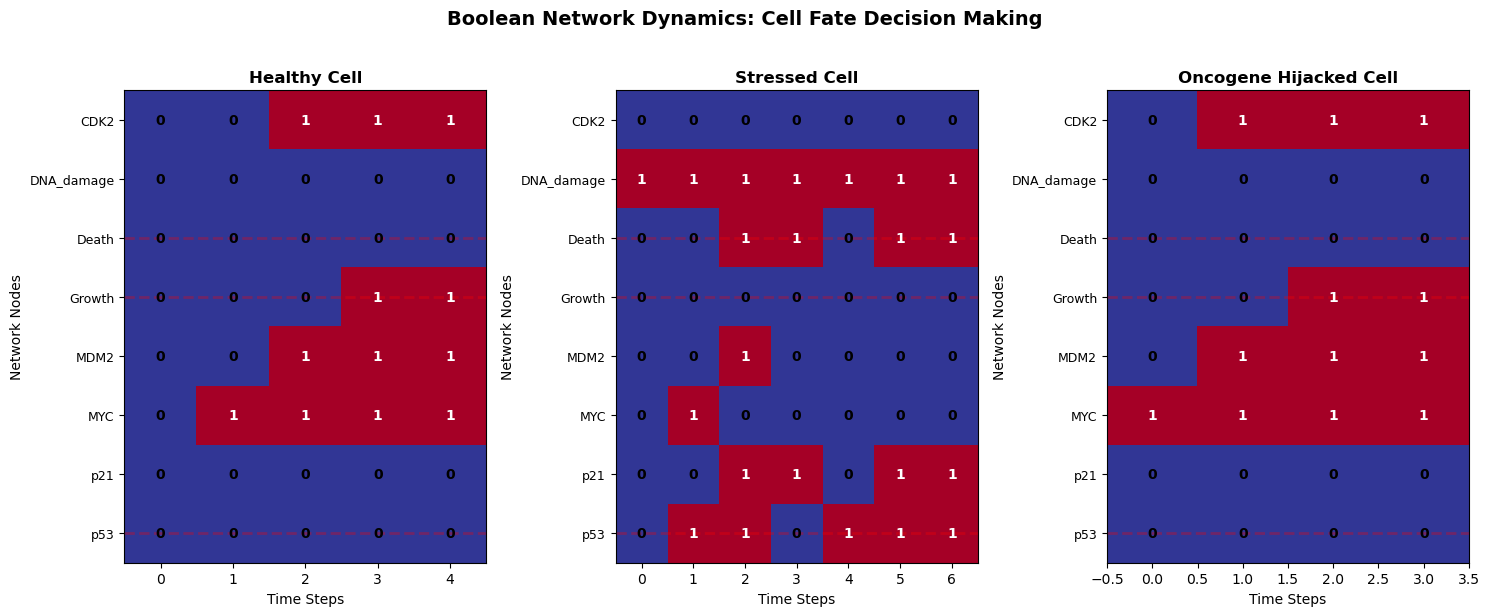

In [12]:
# 🟢 Visualize results
n_scenarios = len(results)
fig, axes = plt.subplots(1, n_scenarios, figsize=(5*n_scenarios, 6))

if n_scenarios == 1:
    axes = [axes]

for scenario_idx, (scenario_name, trajectory) in enumerate(results.items()):
    ax = axes[scenario_idx]

    # Create heatmap
    trajectory_matrix = trajectory.T  # Transpose for proper orientation

    im = ax.imshow(trajectory_matrix, cmap='RdYlBu_r', aspect='auto', interpolation='nearest')

    # Formatting
    ax.set_title(f'{scenario_name}', fontweight='bold', fontsize=12)
    ax.set_xlabel('Time Steps', fontsize=10)
    ax.set_ylabel('Network Nodes', fontsize=10)
    ax.set_yticks(range(len(node_names)))
    ax.set_yticklabels(node_names, fontsize=9)

    # Add text annotations
    for t in range(trajectory.shape[0]):
        for n in range(len(node_names)):
            color = 'white' if trajectory_matrix[n, t] == 1 else 'black'
            ax.text(t, n, int(trajectory_matrix[n, t]),
                   ha="center", va="center", color=color, fontweight='bold')

    # Highlight key output nodes
    output_indices = [i for i, name in enumerate(node_names) if name in ['Growth', 'Death', 'p53']]
    for output_idx in output_indices:  # Changed variable name to avoid conflict
        ax.axhline(y=output_idx, color='red', linestyle='--', alpha=0.3, linewidth=2)

plt.suptitle('Boolean Network Dynamics: Cell Fate Decision Making',
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

❓ **Question**: Were your predictions for each scenario correct? - Yes
1. Which scenario leads to cell growth? - Healthy cell and Oncogene Hijacked Cell scenarios 
2. Which scenario leads to cell death? - Stressed cell scenario
3. How does p53 affect MYC? - One of the necessary conditions for MYC to be on is that p53 is off, as then (NOT p53) is 1. Biologacly, it means that MYC, which is a growth promoter will work only when the 'tumor supressor' - p53 is not active, preventing it from detecting any problems. 
4. What happens when there's no DNA damage? - with no DNA damage (DNA_Damage = 0), the cell never ends up in the Death state, as DNA_Damage = 1 is one of its requirements. It also causes the p53 molecule to be off (p53 = 0), which means that it cannot detect any problems and resolve them, allowing the cell to continue proliferating, which could contribute to tumor growth. 


---

## **Part 3: Attractor analysis**

Attractors = stable states the network eventually reaches from any starting point

Types:
* Fixed Point: Network stops changing (steady state)
* Limit Cycle: Network oscillates in repeating pattern  

Why is this important?
* Represent system's natural 'destinations'
* Can predict long-term behavior
* Identify stable patterns in system
* Design interventions to reach desired attractors

In [18]:
# 🟡 Let's find the attractor states
import itertools
attractors = []
max_steps=15
node_names = sorted(network.nodes.keys())
n_nodes = len(node_names)

print(f"Testing all {2**n_nodes} possible initial states...")

# TODO: Generate all possible initial states
# Hint: Use itertools.product([0, 1], repeat=n_nodes)
all_states = itertools.product([0,1], repeat=n_nodes)

for initial_state in all_states:
  # Set the network to this initial state
  state_dict = {node_names[i]: initial_state[i] for i in range(n_nodes)}
  network.set_state(**state_dict)

  # TODO: Simulate the network
  trajectory = network.simulate(max_steps)

  # Check if it reached a steady state (last two states are the same)
  if len(trajectory) >= 2:
    final_state = tuple(trajectory[-1])  # Convert to tuple for comparison

  # Check if this is a new attractor
    if np.array_equal(trajectory[-1], trajectory[-2]):  # Steady state reached
      if final_state not in attractors:
        attractors.append(final_state)

Testing all 256 possible initial states...
   Reached steady state after 4 steps
   Reached steady state after 6 steps
   Reached steady state after 5 steps
   Reached steady state after 6 steps
   Reached steady state after 3 steps
   Reached steady state after 6 steps
   Reached steady state after 5 steps
   Reached steady state after 6 steps
   Reached steady state after 4 steps
   Reached steady state after 6 steps
   Reached steady state after 5 steps
   Reached steady state after 6 steps
   Reached steady state after 3 steps
   Reached steady state after 6 steps
   Reached steady state after 5 steps
   Reached steady state after 6 steps
   Reached steady state after 4 steps
   Reached steady state after 6 steps
   Reached steady state after 5 steps
   Reached steady state after 6 steps
   Reached steady state after 3 steps
   Reached steady state after 6 steps
   Reached steady state after 5 steps
   Reached steady state after 6 steps
   Reached steady state after 4 steps
   Reac

❓ **Questions and interpretation**
1. How many total states did we test? - 256 states = 2^8 for 8 nodes
2. Why does the number of states grow so quickly? - it grows exponentially following the formula 2^n, where n is the number of nodes, because adding a new node, gives us two new possible states (on/off), so we have 2 * 2^n different combinations of all states.
3. What would happen if we had 15 nodes instead of 8? - then we would have 2^15 = 32768 possible states to check (it becomes computationaly expensive very quickly).


---


FOUND 3 ATTRACTORS:

Attractor 1: [1, 0, 0, 1, 1, 1, 0, 0]
   Growth: ON
   Death: OFF
   p53: OFF
   DNA Damage: OFF
   → It means that the cell can continue proliferation and allow the tumor to grow, as there is no DNA_Damage active, which allows p53 to detect and resolve any problems

Attractor 2: [0, 1, 1, 0, 0, 0, 1, 1]
   Growth: OFF
   Death: ON
   p53: ON
   DNA Damage: ON
   → It means that the cell undergoes apoptosis properly, allowing it to function normally and prevent excessive growth and propagation of damaged DNA.

Attractor 3: [1, 1, 0, 1, 1, 1, 0, 0]
   Growth: ON
   Death: OFF
   p53: OFF
   DNA Damage: ON
   → Even though the DNA_damage is active, some safeguard fails (potentially p53) and leaves the growth pathway active.


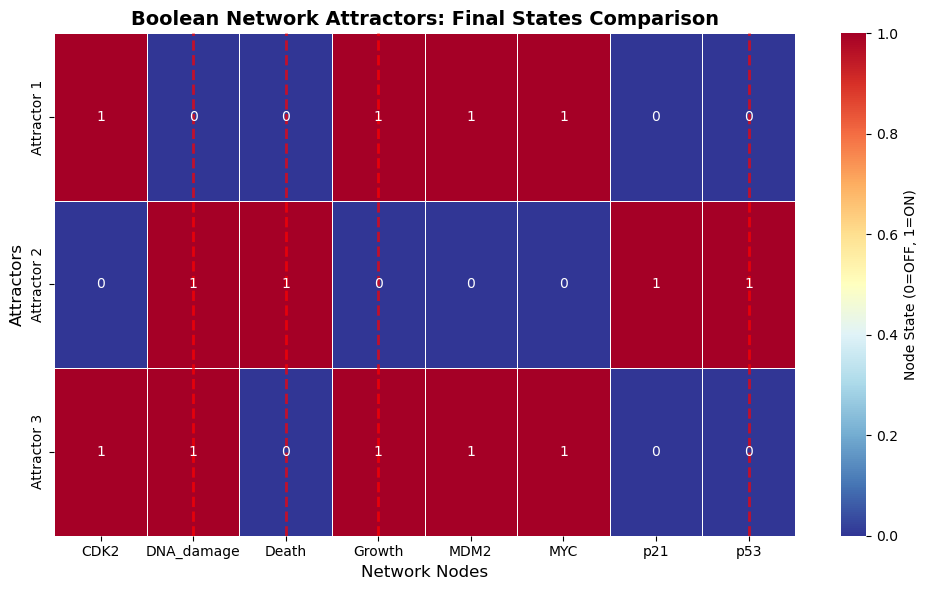

In [26]:
# 🟡 Let's find the attractor states

print(f"\nFOUND {len(attractors)} ATTRACTORS:")

for i, attractor in enumerate(attractors):
        print(f"\nAttractor {i+1}: {list(attractor)}")

        # Create state dictionary for easy access
        state_dict = {node_names[j]: attractor[j] for j in range(len(node_names))}

        # Analyze the biological meaning
        growth_active = state_dict['Growth'] == 1
        death_active = state_dict['Death'] == 1
        p53_active = state_dict['p53'] == 1
        dna_damage_active = state_dict['DNA_damage'] == 1


        print(f"   Growth: {'ON' if growth_active else 'OFF'}")
        print(f"   Death: {'ON' if death_active else 'OFF'}")
        print(f"   p53: {'ON' if p53_active else 'OFF'}")
        print(f"   DNA Damage: {'ON' if dna_damage_active else 'OFF'}")

        # TODO: Interpret the meaning
        if growth_active and not death_active and not dna_damage_active:
            interpretation = "It means that the cell can continue proliferation and allow the tumor to grow, as there is no DNA_Damage active, which allows p53 to detect and resolve any problems"
        elif death_active and not growth_active:
            interpretation = "It means that the cell undergoes apoptosis properly, allowing it to function normally and prevent excessive growth and propagation of damaged DNA."
        elif growth_active and not death_active and dna_damage_active:
            interpretation = "Even though the DNA_damage is active, some safeguard fails (potentially p53) and leaves the growth pathway active."
        else:
            interpretation = "CONFLICT - Unusual state"

        print(f"   → {interpretation}")


# Convert attractors to clean matrix
attractor_matrix = []
for attractor in attractors:
    clean_row = [int(x) for x in attractor]
    attractor_matrix.append(clean_row)

attractor_matrix = np.array(attractor_matrix)

# Create heatmap
plt.figure(figsize=(10, max(6, len(attractors))))

# Create heatmap with custom colors
ax = sns.heatmap(attractor_matrix,
                 xticklabels=node_names,
                 yticklabels=[f'Attractor {i+1}' for i in range(len(attractors))],
                 cmap='RdYlBu_r',
                 cbar_kws={'label': 'Node State (0=OFF, 1=ON)'},
                 annot=True,
                 fmt='d',
                 linewidths=0.5)

plt.title('Boolean Network Attractors: Final States Comparison',
          fontsize=14, fontweight='bold')
plt.xlabel('Network Nodes', fontsize=12)
plt.ylabel('Attractors', fontsize=12)

# Highlight key output nodes
output_nodes = ['Growth', 'Death', 'p53', 'DNA_damage']
for node in output_nodes:
    if node in node_names:
        idx = node_names.index(node)
        ax.axvline(x=idx+0.5, color='red', linestyle='--', alpha=0.7, linewidth=2)

plt.tight_layout()
plt.show()

❓ **Questions and interpretation**
1. How many attractors did we find? - we found 3 attractors
2. What does each attractor represent biologically? - Attractor 1 represents a state where the cell can grow naturally and normally, as there is no damaged DNA. Because of that, no p53 is needed to detect any problems. Attractor 2 represents a state where the DNA is damaged, however the cell isn't growing (Growth is off), which means that the p53 safeguard mechanism is working properly and removing the waste from the cell through apoptosis (Death is on). Attractor 3 represents a state where the DNA is damaged but the cell continues to grow (even in presence of p53 safeguard mechanisms), which can be a sign of cancerous state. Attractor 3
4. Which attractor represents a 'healthy' cell state and which one a cancerous' cell state?
Attractor 1 represents a healthy cell and Attractor 3 represents the cancerous' cell state.

Analyzing 256 initial states...
   Reached steady state after 4 steps
   Reached steady state after 6 steps
   Reached steady state after 5 steps
   Reached steady state after 6 steps
   Reached steady state after 3 steps
   Reached steady state after 6 steps
   Reached steady state after 5 steps
   Reached steady state after 6 steps
   Reached steady state after 4 steps
   Reached steady state after 6 steps
   Reached steady state after 5 steps
   Reached steady state after 6 steps
   Reached steady state after 3 steps
   Reached steady state after 6 steps
   Reached steady state after 5 steps
   Reached steady state after 6 steps
   Reached steady state after 4 steps
   Reached steady state after 6 steps
   Reached steady state after 5 steps
   Reached steady state after 6 steps
   Reached steady state after 3 steps
   Reached steady state after 6 steps
   Reached steady state after 5 steps
   Reached steady state after 6 steps
   Reached steady state after 4 steps
   Reached steady 

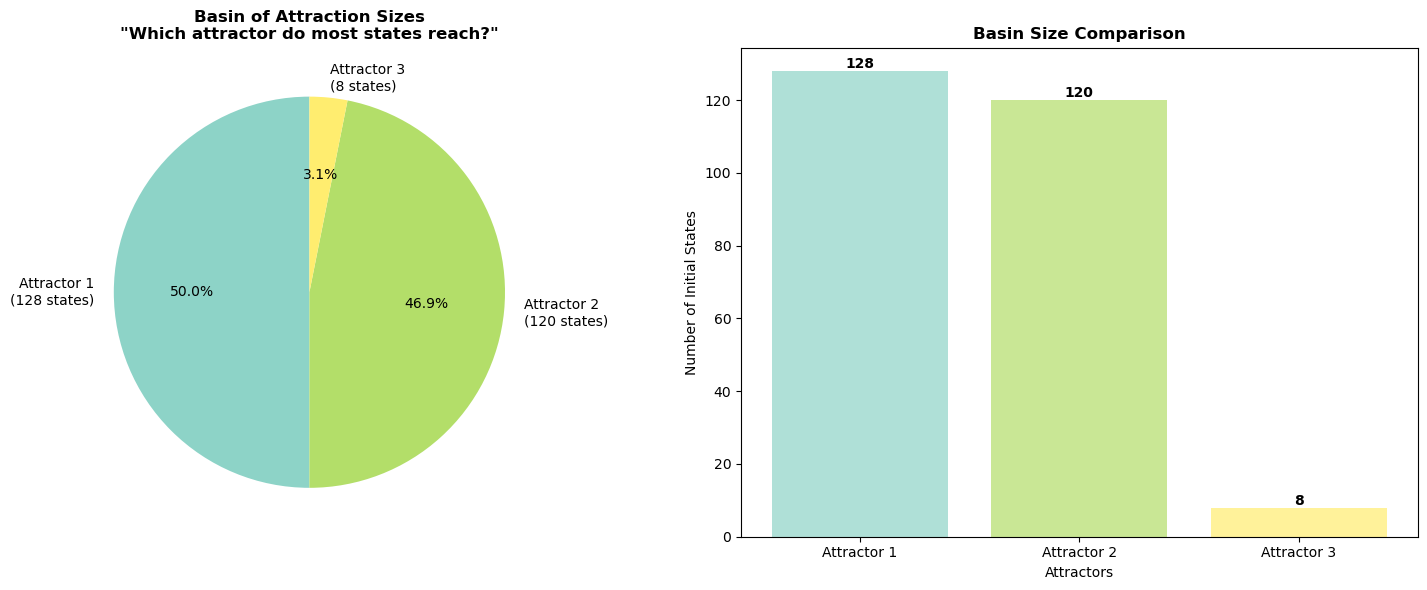

In [25]:
# 🟡 Which states end up in which attractor?

# Track which initial states lead to which attractors
basin_data = defaultdict(list)  # attractor -> list of initial states
attractor_map = {}  # initial_state -> attractor_index

n_nodes = len(node_names)
all_states = list(product([0, 1], repeat=n_nodes))
print(f"Analyzing {len(all_states)} initial states...")

for initial_state in all_states:
    # Set network state
    state_dict = {node_names[i]: initial_state[i] for i in range(n_nodes)}
    network.set_state(**state_dict)

    # Simulate
    trajectory = network.simulate(steps=max_steps, record_history=True)

    # Find which attractor this leads to
    if len(trajectory) >= 2 and np.array_equal(trajectory[-1], trajectory[-2]):
        final_state = tuple(int(x) for x in trajectory[-1])  # Clean conversion

        # Find matching attractor
        for att_idx, attractor in enumerate(attractors):
            clean_attractor = tuple(int(x) for x in attractor)
            if final_state == clean_attractor:
                basin_data[att_idx].append(initial_state)
                attractor_map[initial_state] = att_idx
                break

# Display basin sizes
print(f"\n Basin Sizes:")
total_states = len(all_states)
for att_idx in range(len(attractors)):
    basin_size = len(basin_data[att_idx])
    percentage = (basin_size / total_states) * 100
    print(f"   Attractor {att_idx+1}: {basin_size:3d} states ({percentage:5.1f}%)")

# Create pie chart of basin sizes
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Pie chart of basin sizes
basin_sizes = [len(basin_data[i]) for i in range(len(attractors))]
basin_labels = [f'Attractor {i+1}\n({size} states)' for i, size in enumerate(basin_sizes)]
colors = plt.cm.Set3(np.linspace(0, 1, len(attractors)))

wedges, texts, autotexts = ax1.pie(basin_sizes,
                                   labels=basin_labels,
                                   colors=colors,
                                   autopct='%1.1f%%',
                                   startangle=90)

ax1.set_title('Basin of Attraction Sizes\n"Which attractor do most states reach?"',
              fontsize=12, fontweight='bold')

# Bar chart comparison
attractor_names = [f'Attractor {i+1}' for i in range(len(attractors))]
bars = ax2.bar(attractor_names, basin_sizes, color=colors, alpha=0.7)

ax2.set_title('Basin Size Comparison', fontsize=12, fontweight='bold')
ax2.set_ylabel('Number of Initial States', fontsize=10)
ax2.set_xlabel('Attractors', fontsize=10)

# Add value labels on bars
for bar, size in zip(bars, basin_sizes):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height, f'{size}',
             ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

❓ **Questions and interpretation**
* How many initial states lead to each attractor? Attractor 1: 128 states, Attractor 2: 120 states, Attractor 3: 8 states
* Which attractors are most "popular" (large basins)? Attractor 1 (50%) and Attractor 2 (46.9%) are the most popular.





# Assignment 3 - Network Biology

## Mutation A: p53 knockout 

## Mutation B:  MYC Amplification

## Mutation C: MDM2 Overexpression

## Mutation D: TBD